In [46]:
import numpy as np
import holotomo
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import tifffile
import cupy as cp
import holotomo
import glob
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

cp.cuda.Device(0).use()

<CUDA Device 0>

In [47]:
n = 136
npos = 16
ndist = 1
data0 = np.zeros([npos,ndist,n,n],dtype='float32')
ref0 = np.zeros([1,n,n],dtype='float32')
dark = np.zeros([1,n,n],dtype='float32')

for k in range(5*16):
    print(205+k)
    file = glob.glob(f'/data/NSLSII/3ID/projection_image3/*{205+k}.tif')
    # print(file)
    data0[k//5] += tifffile.imread(file[0])[785:785+136,278:278+136]

for k in range(5):
    file = glob.glob(f'/data/NSLSII/3ID/projection_image3/*{285+k}.tif')
    dark += tifffile.imread(file[0])[785:785+136,278:278+136]

for k in range(5):
    file = glob.glob(f'/data/NSLSII/3ID/projection_image3/*{200+k}.tif')
    ref0 += tifffile.imread(file[0])[785:785+136,278:278+136]

ref0-=dark
data0-=dark
ref0[ref0<0] = 0
data0[data0<0] = 0
rdata = (data0)/(ref0+1e-6)

def plot_rec(sid=1):
    plt.figure(figsize=(5,4))
    plt.imshow(rdata[sid,0],cmap='gray',vmax=2)    
    plt.colorbar()
interact(plot_rec, sid = widgets.IntSlider(value=0,
                                               min=0,
                                               max=rdata.shape[0]-1,
                                               step=1))    

205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284


interactive(children=(IntSlider(value=0, description='sid', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_rec(sid=1)>

# Dark-flat field correction

In [48]:
energy = 14  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.056 # [m]

detector_pixelsize = 75e-6 # [m]

z1 = np.array([2e-3])[:ndist] # positions of the sample (1 position is enough when using several codes)
z2 = focusToDetectorDistance-z1 # propagation distance between the code and detector
magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the code
voxelsize=detector_pixelsize/magnifications[0]# = 75e-6 # [m]

norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes

# Read motor shifts

In [49]:
shifts_motor = [[0.5,   2.3 ], [0.1,   2.8 ], [0.7, 2.4   ], [0.3,   2.1 ],
          [0.7,   5.2], [0.5,   5.1], [0.2, 5.5  ], [0.3,   5.8],
          [3.7, 2.3 ], [3.5, 2.7 ], [3.2, 2.4 ], [3.9, 2.9 ],
          [3.8, 5.4], [3.5, 5.3], [3.2, 5.8], [3.4, 5.5],
          ]
shifts_motor = np.array(shifts_motor)
shifts_motor = -shifts_motor[:,np.newaxis]/voxelsize*1e-6+np.array([15,26])#*[0.98,0.95]

shifts_motor1 = shifts_motor[4:8]
shifts_motor2 = shifts_motor[8:12]
shifts_motor[4:8] = shifts_motor2
shifts_motor[8:12] = -shifts_motor1


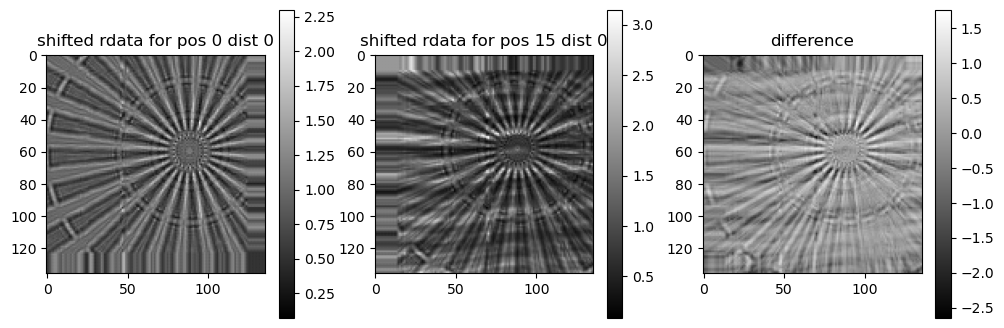

In [50]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'edge')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_new = rdata.copy()    
for k in range(ndist):
    for j in range(npos):
        #print(f'shift for pos {k} dist {j} is {shifts[k,j]}')
        rdata_new[j,k:k+1] = apply_shift(rdata[j,k:k+1],-shifts_motor[j,k:k+1])

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im=axs[0].imshow(rdata_new[0,k],cmap='gray')
    axs[0].set_title(f'shifted rdata for pos 0 dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata_new[-1,k],cmap='gray')
    axs[1].set_title(f'shifted rdata for pos {npos-1} dist {k}')
    fig.colorbar(im)        
    im=axs[2].imshow(rdata_new[0,k]-rdata_new[-1,k],cmap='gray')
    axs[2].set_title(f'difference')
    fig.colorbar(im)        

# Scale everything to 1 magnification

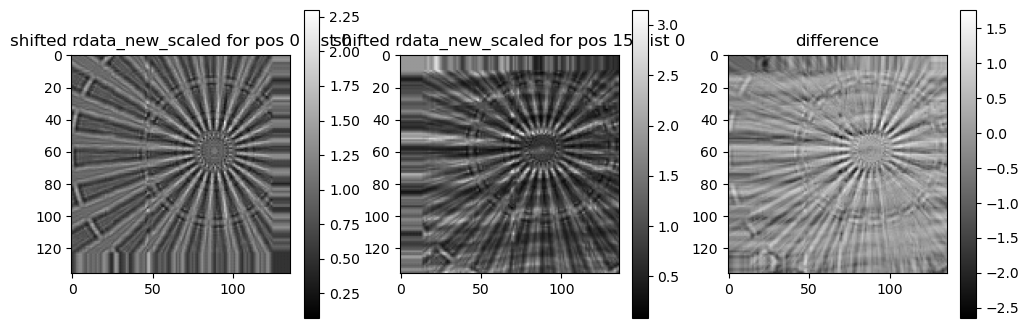

In [51]:
rdata_new_scaled = rdata_new.copy()
for j in range(npos):
    for k in range(ndist):    
        a = ndimage.zoom(rdata_new[j,k],1/norm_magnifications[k])
        rdata_new_scaled[j,k] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]

for k in range(ndist):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    im=axs[0].imshow(rdata_new_scaled[0,k],cmap='gray')
    axs[0].set_title(f'shifted rdata_new_scaled for pos 0 dist {k}')
    fig.colorbar(im)
    im=axs[1].imshow(rdata_new_scaled[-1,k],cmap='gray')
    axs[1].set_title(f'shifted rdata_new_scaled for pos {npos-1} dist {k}')
    fig.colorbar(im)        
    im=axs[2].imshow(rdata_new_scaled[0,k]-rdata_new_scaled[-1,k],cmap='gray')
    axs[2].set_title(f'difference')
    fig.colorbar(im)        

# Align data between different magnifications

In [52]:
def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_dist = np.zeros([npos,ndist,2],dtype='float32')
for j in range(npos):
    for k in range(ndist):
        shifts_dist[j,k] = registration_shift(rdata_new_scaled[j,k:k+1],rdata_new_scaled[0,0:1],upsample_factor=10)
        print(f'{k} {j}: {shifts_dist[j,k]}')

0 0: [0. 0.]
0 1: [ 0.3 -0.1]
0 2: [ 0.2 -0.2]
0 3: [ 0.4 -0.1]
0 4: [-0.1 -0.7]
0 5: [-0.1 -0.6]
0 6: [-0.5 -0.5]
0 7: [-0.8 -0.8]
0 8: [-1.3 -1.5]
0 9: [ 1.3 -3.6]
0 10: [ 5.5 -4.3]
0 11: [ -0.3 -10. ]
0 12: [-1.6 -1.2]
0 13: [-1.8 -1. ]
0 14: [-1.9 -1.1]
0 15: [-2.1 -1.1]


# Total shifts in pixels before normalized scaling

In [53]:
shifts = shifts_motor+shifts_dist
shifts = cp.array(shifts)

# TEST: Scale initial data to 1 magnification and apply all shifts

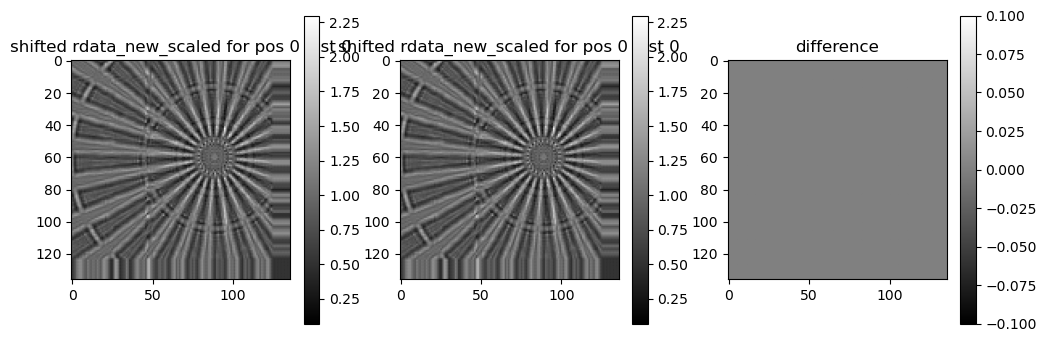

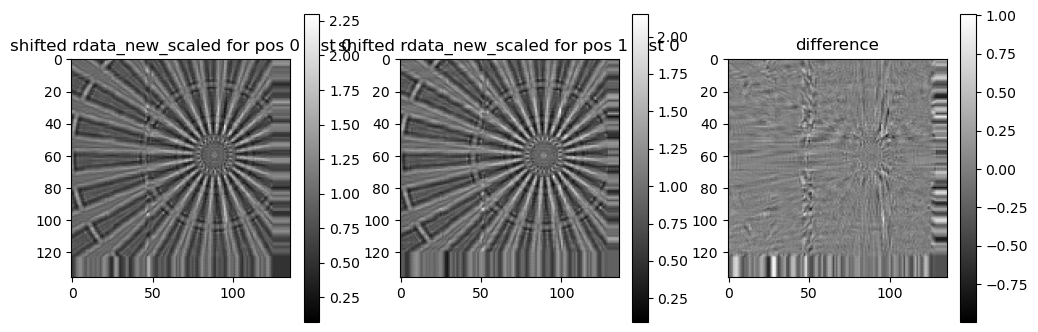

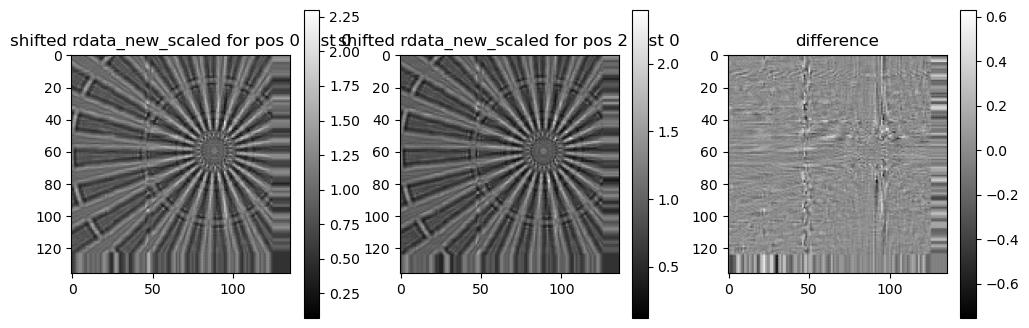

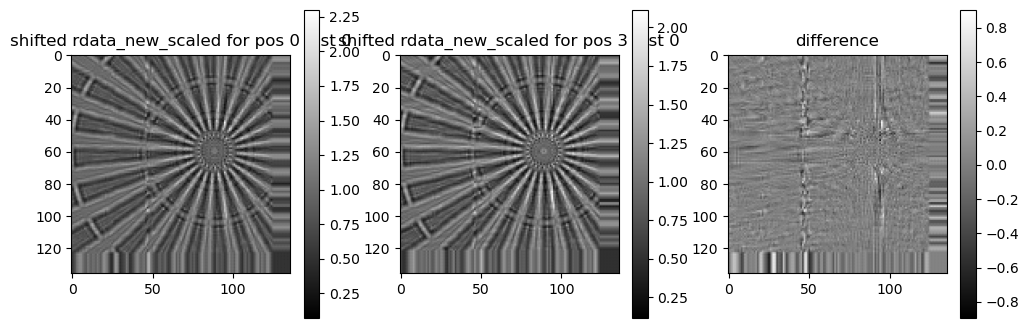

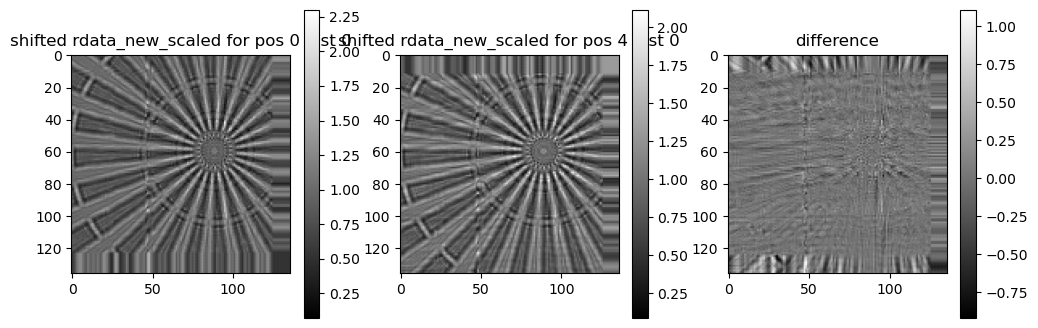

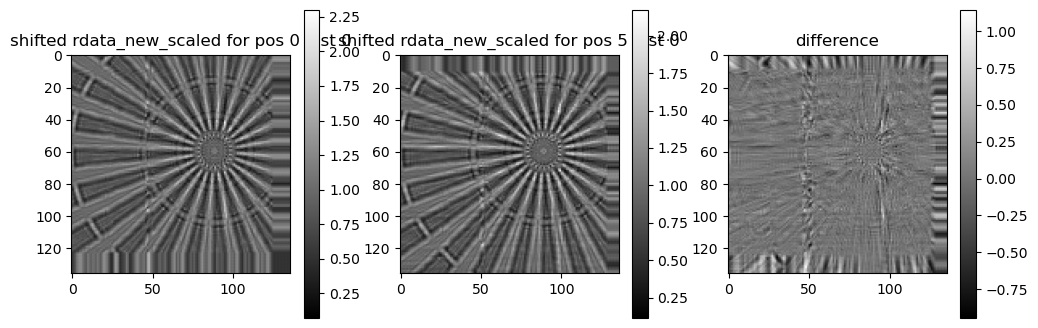

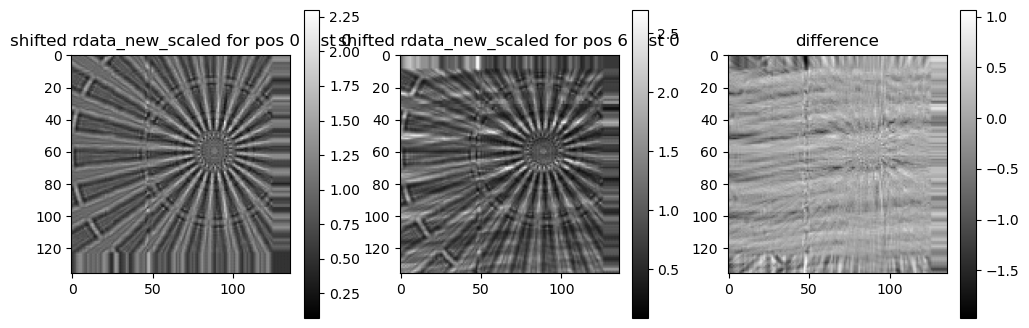

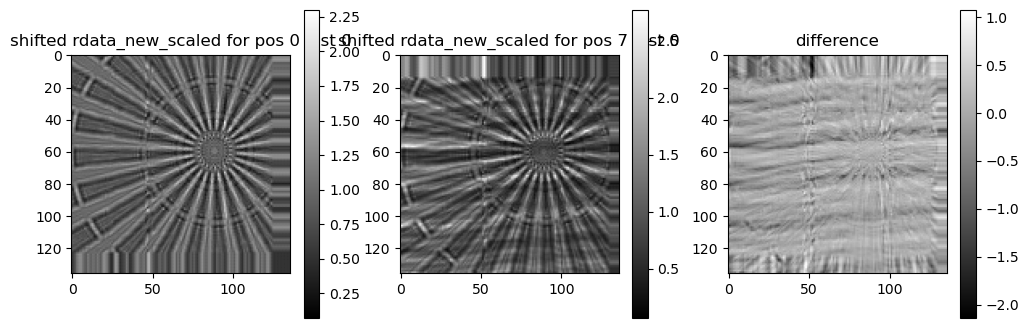

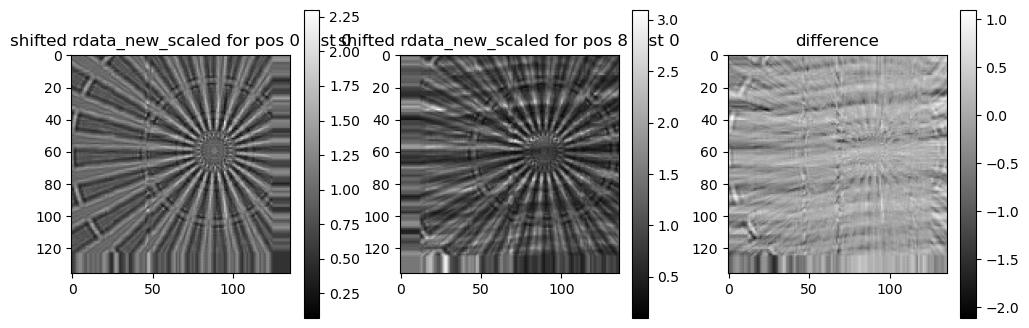

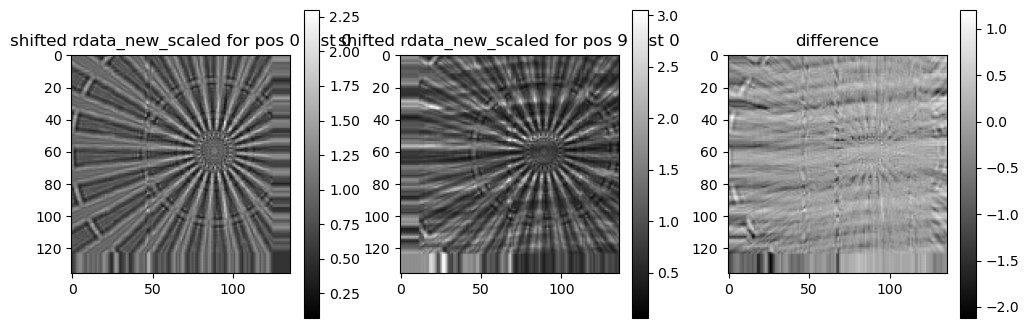

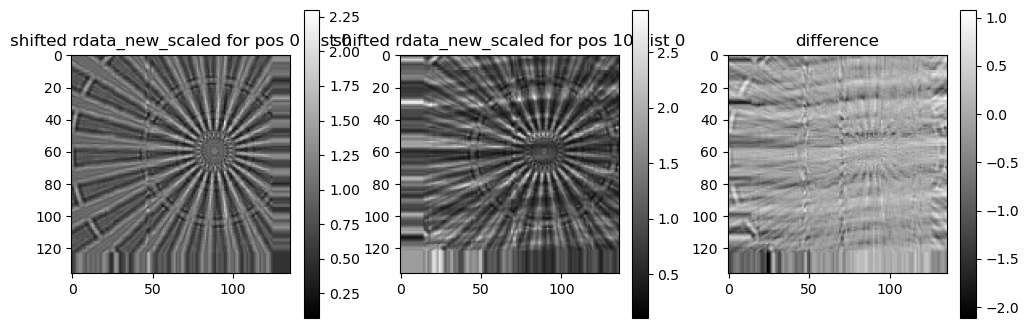

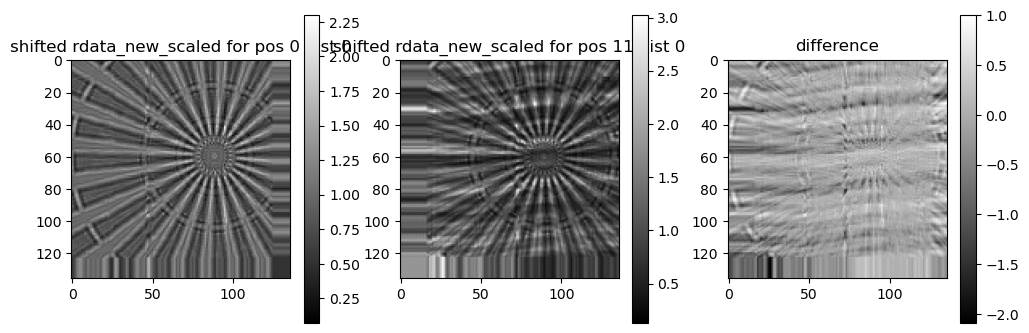

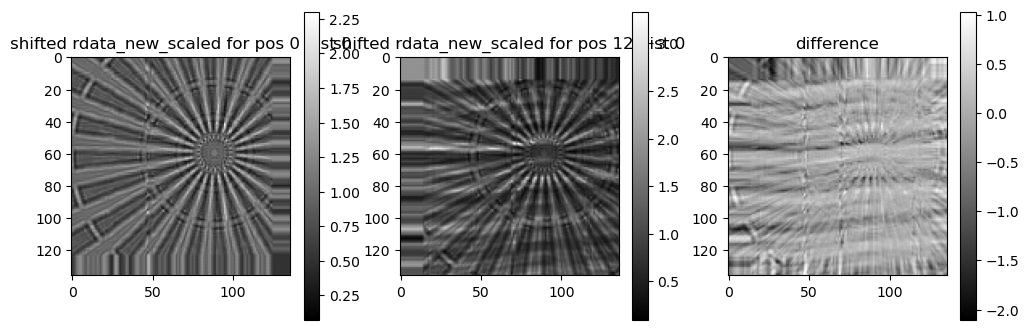

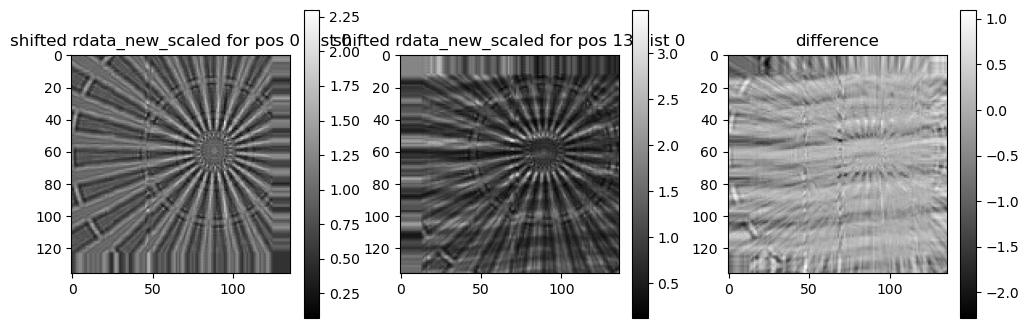

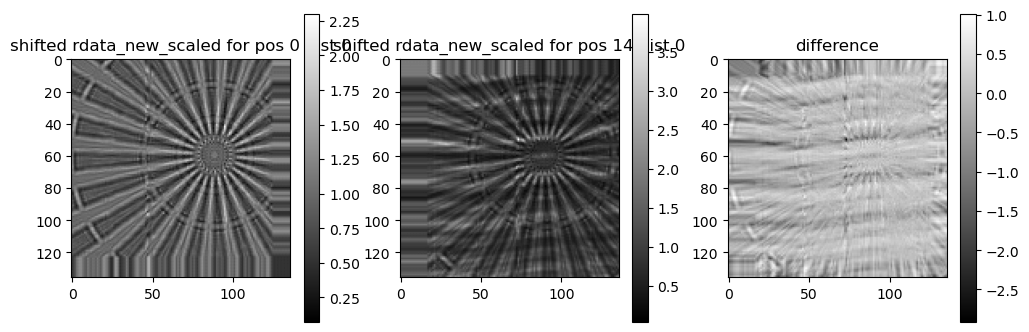

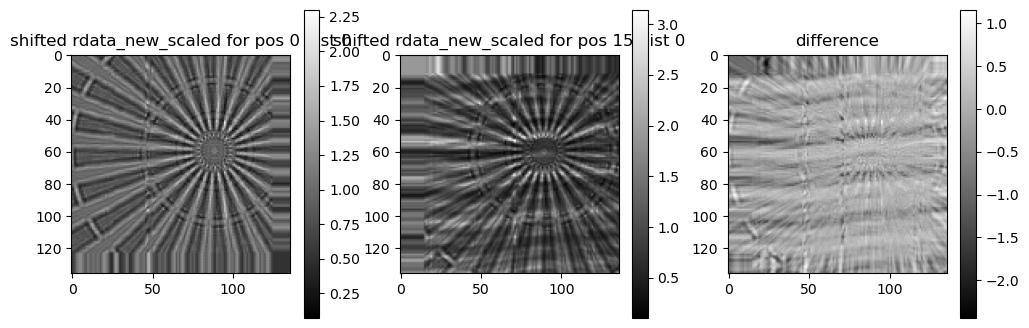

In [54]:
# shifts/=norm_magnifications[:,np.newaxis]
rdata_scaled = rdata.copy()
for j in range(npos):
    for k in range(ndist):    
        a = apply_shift(rdata[j,k:k+1],-shifts[j,k:k+1])[0]# note first shift then magnification
        a = ndimage.zoom(a,1/norm_magnifications[k])
        rdata_scaled[j,k] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]        
        # a = rdata[j,k].copy()        
        # a = ndimage.zoom(a,1/norm_magnifications[k])
        # a = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]        
        # a = apply_shift(a[np.newaxis],-shifts[j,k:k+1])[0]# note first shift then magnification
        # rdata_scaled[j,k] = a
        # a = ndimage.zoom(a,1/norm_magnifications[k])
        # rdata_scaled[j,k] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]        
for j in range(npos):
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled[0,0],cmap='gray')
        axs[0].set_title(f'shifted rdata_new_scaled for pos 0 dist 0')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled[j,k],cmap='gray')
        axs[1].set_title(f'shifted rdata_new_scaled for pos {j} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled[0,0]-rdata_scaled[j,k],cmap='gray')
        axs[2].set_title(f'difference')
        fig.colorbar(im)        

In [55]:
data = data0[:,:,np.newaxis]# adding angular dim
ref = ref0.copy()
print(data.shape)

(16, 1, 1, 136, 136)


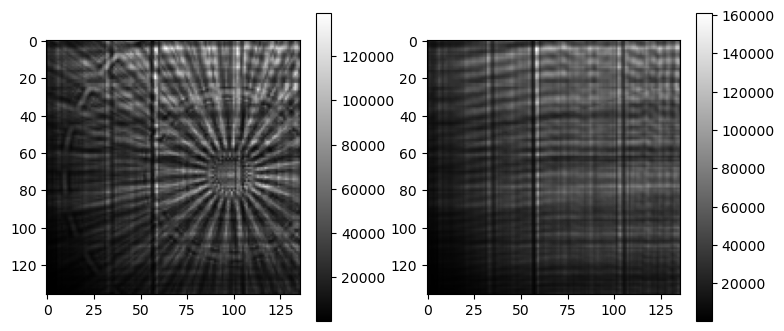

In [56]:
for k in range(ndist):
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(data[0,k,0],cmap='gray')
    fig.colorbar(im)
    im=axs[1].imshow(ref[k],cmap='gray')
    fig.colorbar(im)        
    

# Create solver class

In [57]:
pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[0:1], norm_magnifications[0:1]) 

## Goal: recover the sample and probe simultaneously $\ \sum_i\sum_j||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi,q}$ 

$i$ - index for the NFP shifts\
$j$ - index for planes \
$\psi$ - sample at plane 0 \
$q$ - probe at plane 0\
$M_j$ - object normalized (de-)magnification for the plane $j$ \
$S_r$ - shift for distance r (x and y), NFP shifts + alignment shifts \
$\mathcal{G}_d$ - Fresnel transform for distance $d$

## Holotomography can be obtained by associating index $i$ with angles (no NFP)
## $\sum_i\sum_j||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi_i,q} $

## Define forward operators as 
### $\psi \to \mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_jS_{r_{ij}}\psi))$, where $i = 0 \dots 15$, $j = 0 \dots 3$ 
### $q \to \mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_jS_{r_{ij}}\psi))$, where $i = 0 \dots 15$, $j = 0 \dots 3$, 
## The adjoint operators are then 
### $\sigma[\psi]\to \sum_j\sum_i M_j^*S_{-r_{ij}}((\mathcal{G}_{d'_j}q)^*\mathcal{G}_{-d_{j}}\sigma)$, 
### $\sigma[q]\to \sum_j\sum_i \mathcal{G}_{-d'_j}((M_jS_{r_{ij}}\psi)^*\mathcal{G}_{-d_j}\sigma)$

# Check double propagation

[0.00199621] [0.]
(16, 1, 1, 136, 136)


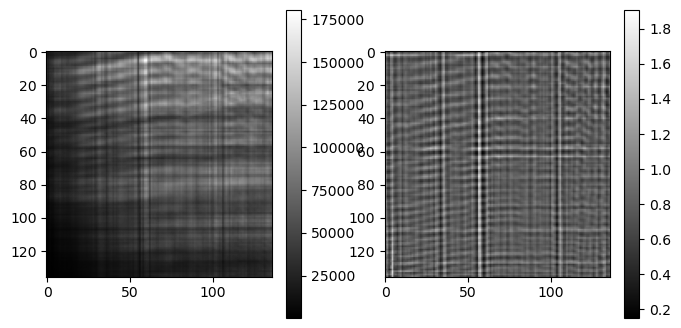

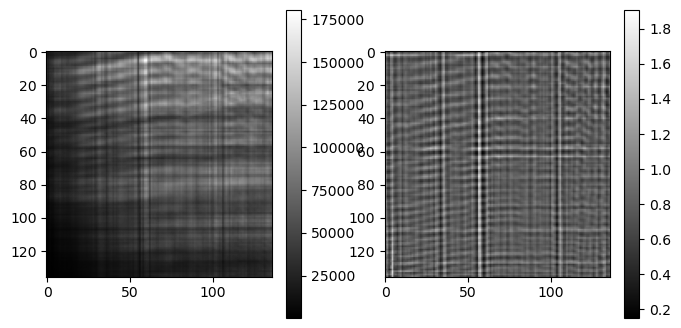

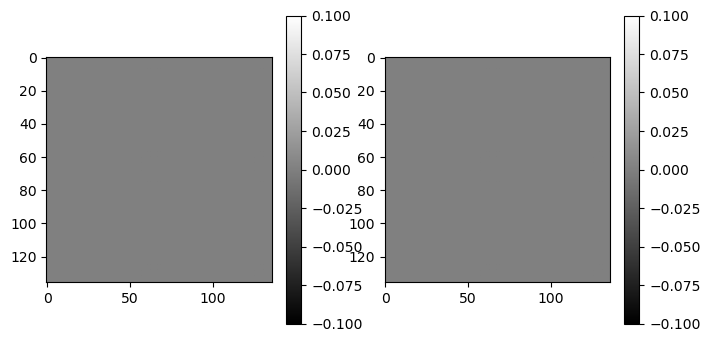

In [58]:
z1p = np.tile(np.array(z1[0]),ndist)# positions of the sample
z2p = z1-z1p

magnifications2 = (z1p+z2p)/z1p # magnification when propagating from the sample to the detector
distances2 = (z1p*z2p)/(z1p+z2p) # propagation distances after switching from the point source wave to plane wave,
norm_magnifications2 = magnifications2/magnifications2[0] # normalized magnifications
distances2 = distances2*norm_magnifications2**2 # scaled propagation distances due to magnified probes
distances2 = distances2*(z1p/z1)**2

print(distances,distances2)
pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2) 

print(data.shape)
# arr1 = cp.pad(cp.array(data+1j*data).astype('complex64'),((1,1),(1,1),(1,1),(n//2,n//2),(n//2,n//2)),'symmetric')
# prb1 = cp.array(ref+1j*ref).astype('complex64')
arr1 = cp.pad(cp.array(data[0,0]+1j*data[0,0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')


ddata1 = pslv.fwd_holo(arr1*0+1,prb1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im=axs[0].imshow(np.abs(ddata1[0,0].get()),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(ddata1[0,0].get()),cmap='gray')#,vmin=1,vmax=2.5)
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im=axs[0].imshow(np.abs(ddata1[-1,0].get()),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(ddata1[-1,0].get()),cmap='gray')#,vmin=1,vmax=2.5)
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im=axs[0].imshow(np.abs(ddata1[-1,0].get())-np.abs(ddata1[0,0].get()),cmap='gray')
fig.colorbar(im)
im=axs[1].imshow(np.angle(ddata1[-1,0].get())-np.angle(ddata1[0,0].get()),cmap='gray')
fig.colorbar(im)

# Adjoint test for holography with double propagation

In [59]:
arr1 = cp.pad(cp.array(data[0,0]+1j*data[0,0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')
print(arr1.shape)
print(prb1.shape)
arr2 = pslv.fwd_holo(arr1,prb1)
arr3 = pslv.adj_holo(arr2,prb1)
prb3 = pslv.adj_holo_prb(arr2,arr1)


print(cp.sum(arr1*cp.conj(arr3)))
print(cp.sum(arr2*cp.conj(arr2)))
print(cp.sum(prb1*cp.conj(prb3)))

(1, 272, 272)
(1, 136, 136)
(3.7646814e+23+8384383000000000j)
(3.7646814e+23-68331390000000j)
(3.7646814e+23+1.715781e+16j)


In [60]:
def fwd_nfp(pslv,psi,prb,shifts):
    fpsi = cp.zeros([shifts.shape[0],shifts.shape[1],1,n,n],dtype='complex64')
    for j in range(shifts.shape[0]):        
        fpsi[j] = pslv.fwd_holo(psi,prb,shifts[j])                      
    return fpsi

def adj_nfp(pslv,fpsi,prb,shifts):
    psi = cp.zeros([1,2*n,2*n],dtype='complex64')
    for j in range(shifts.shape[0]):        
        psi += pslv.adj_holo(fpsi[j],prb,shifts[j])                                   
    return psi

def adj_nfp_prb(pslv,fprb,psi,shifts):
    prb = cp.zeros([1,n,n],dtype='complex64')
    for j in range(shifts.shape[0]):        
        prb += pslv.adj_holo_prb(fprb[j],psi,shifts[j])           
    return prb

# Adjoint test

In [61]:
arr1 = cp.pad(cp.array(data[0,0]+1j*data[0,0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = cp.array(ref[:1]+1j*ref[:1]).astype('complex64')
arr2 = fwd_nfp(pslv,arr1,prb1,shifts)
arr3 = adj_nfp(pslv,arr2,prb1,shifts)
prb3 = adj_nfp_prb(pslv,arr2,arr1,shifts)

print(cp.sum(arr1*cp.conj(arr3)))
print(cp.sum(arr2*cp.conj(arr2)))
print(cp.sum(prb1*cp.conj(prb3)))

(4.5015304e+24-9.380593e+16j)
(4.50153e+24-48161184000000j)
(4.501531e+24+2.9584731e+16j)


## Gradient descent with the line search

In [62]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
    
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while(minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(pslv, data, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = fwd_nfp(pslv,psi,prb,shifts)            
            grad = adj_nfp(pslv,
               fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2
                    
            d = -grad    
            # line search
            fd = fwd_nfp(pslv, d, prb,shifts)
            gammapsi = line_search(minf, 1, fpsi, fd)
            psi = psi+gammapsi*d
            
            if i%step==0:
                fig, axs = plt.subplots(2, 2, figsize=(15, 15))
                im=axs[0,0].imshow(np.abs(psi[0].get()),cmap='gray')
                axs[0,0].set_title('reconstructed amplitude')
                fig.colorbar(im)
                im=axs[0,1].imshow(np.angle(psi[0].get()),cmap='gray')
                axs[0,1].set_title('reconstructed phase')
                fig.colorbar(im)
                im=axs[1,0].imshow(np.angle(psi[0,n//2:-n//2,n//2:-n//2].get()),cmap='gray')
                axs[1,0].set_title('reconstructed phase')
                fig.colorbar(im)
                im=axs[1,1].imshow(np.angle(psi[0,n//2+n//4:-n//2-n//4,n//2+n//4:-n//2-n//4].get()),cmap='gray')
                axs[1,1].set_title('reconstructed phase')
                fig.colorbar(im)
                plt.show()
                fpsi = fwd_nfp(pslv,psi,prb,shifts)                            
                err=minf(fpsi)            
                print(f'{i}) {gammapsi=}, {err=:1.5e}')    
           
        if upd_prb:
            fprb = fwd_nfp(pslv,psi,prb,shifts)
            gradprb = adj_nfp_prb(pslv,fprb-cp.sqrt(data)*cp.exp(1j*cp.angle(fprb)),psi,shifts)/cp.max(cp.abs(psi))**2/pslv.ntheta#/ndist**2

            dprb = -gradprb
            # gradprb0 = gradprb
            # line search
            fdprb = fwd_nfp(pslv,psi, dprb,shifts)
            gammaprb = line_search(minf, 1, fprb, fdprb)
            prb = prb + gammaprb*dprb
            
            if i%step==0:
                fprb = fwd_nfp(pslv,psi,prb,shifts)
                err=minf(fprb)
                print(f'{i}) {gammaprb=}, {err=:1.5e}')    
        
    return psi,prb

def cg_holo_batch(pslv, data, init, prb_init, piter,shifts=None,upd_psi=True,upd_prb=False,step=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,:,ids])
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, data_gpu, init_gpu,prb_init_gpu, piter,shifts,upd_psi, upd_prb,step)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb



# Estimate probe using one reference image $\||\mathcal{G}_{d_0}q|-\sqrt{\text{I}_{r_0}}\|^2_2\to \text{min}$, taken for distance 0


(1, 1, 1, 136, 136)
0) gammaprb=1, err=1.36820e-03
8) gammaprb=1, err=2.01538e-05
16) gammaprb=1, err=2.06952e-05


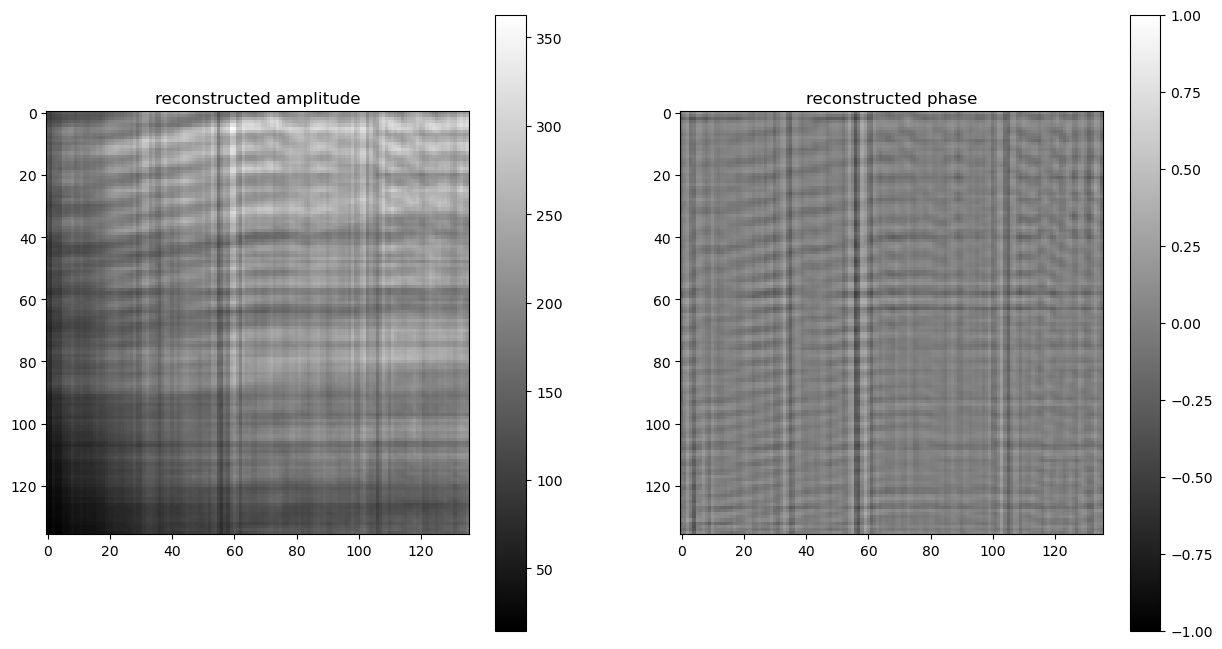

In [63]:
rec = np.ones([1,2*n,2*n],dtype='complex64')
rec_prb = np.ones([1,n,n],dtype='complex64')        
data_ref = ref[:1,np.newaxis,np.newaxis]
print(data_ref.shape)
shifts_ref = (shifts/cp.array(norm_magnifications[:,np.newaxis]))[:1,:1]*0
pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distances2[:1]) 
_,rec_prb0 = cg_holo_batch(pslv, data_ref, rec, rec_prb, 17, shifts_ref, False,True,8)

fig, axs = plt.subplots(1, 2, figsize=(15, 8))

im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray',vmin=-1,vmax=1)
axs[1].set_title('reconstructed phase')
fig.colorbar(im)


## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi,q}$ 

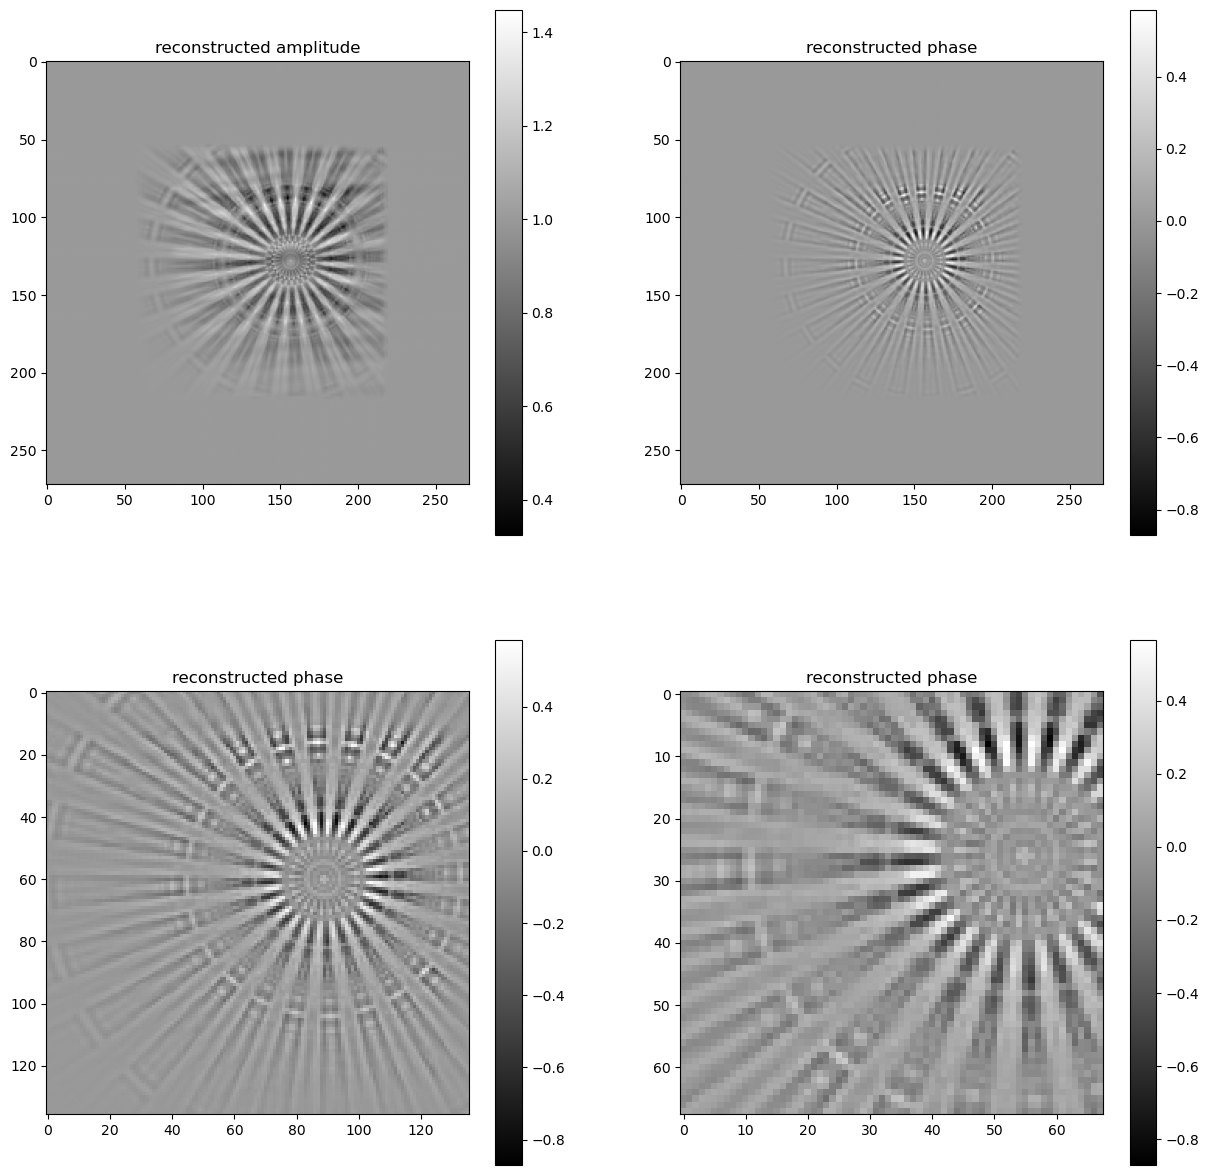

0) gammapsi=0.25, err=1.21330e+08
0) gammaprb=0.25, err=1.10928e+08


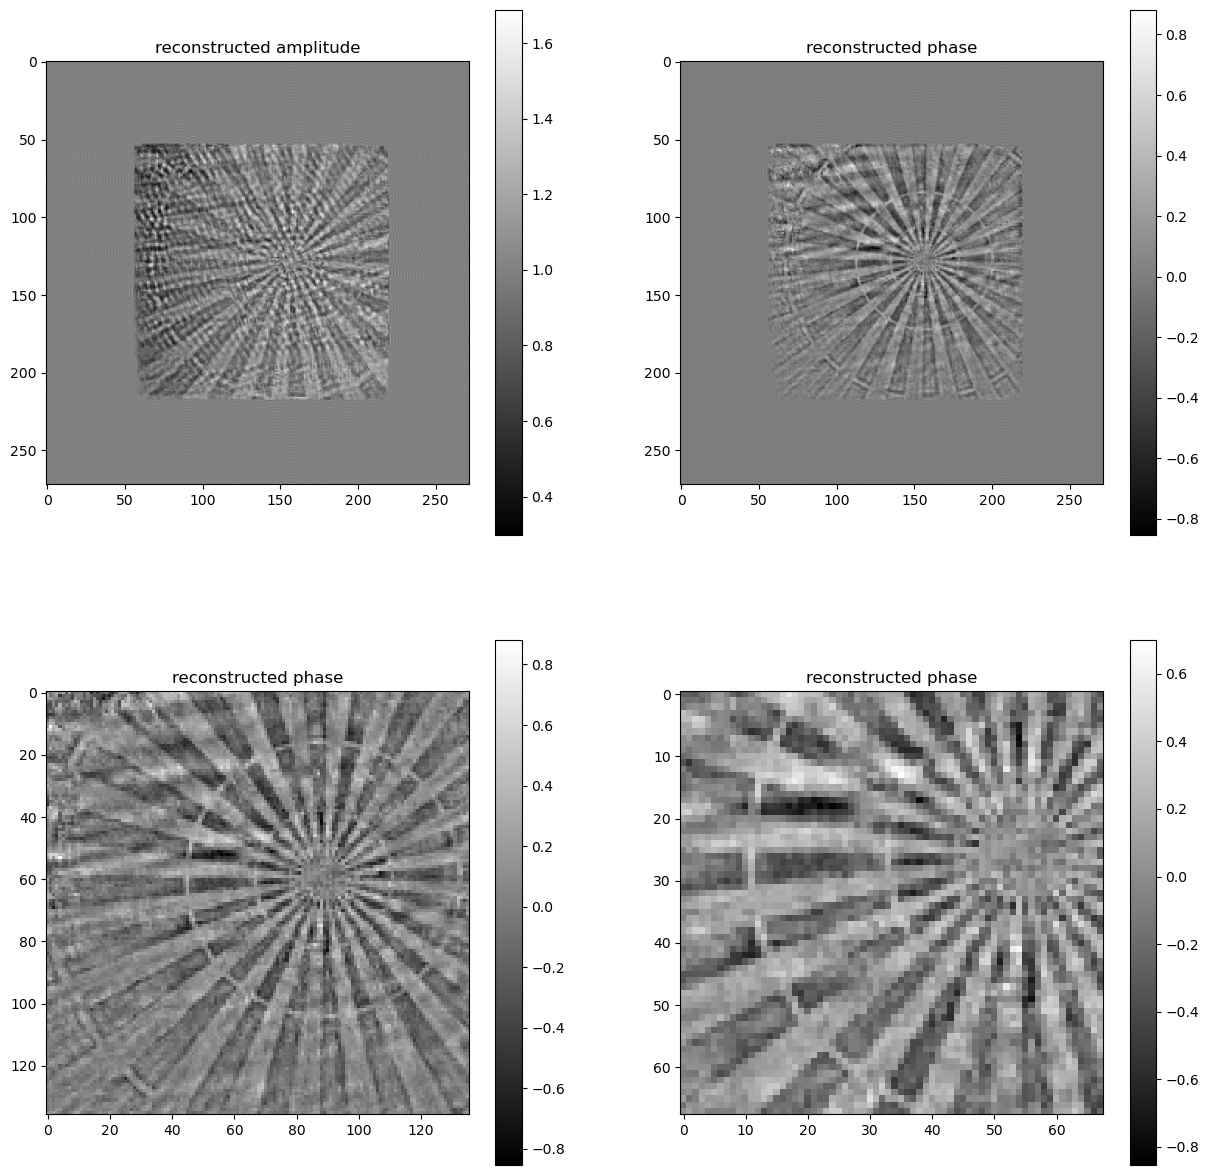

256) gammapsi=0.25, err=2.17186e+07
256) gammaprb=0.5, err=2.17166e+07


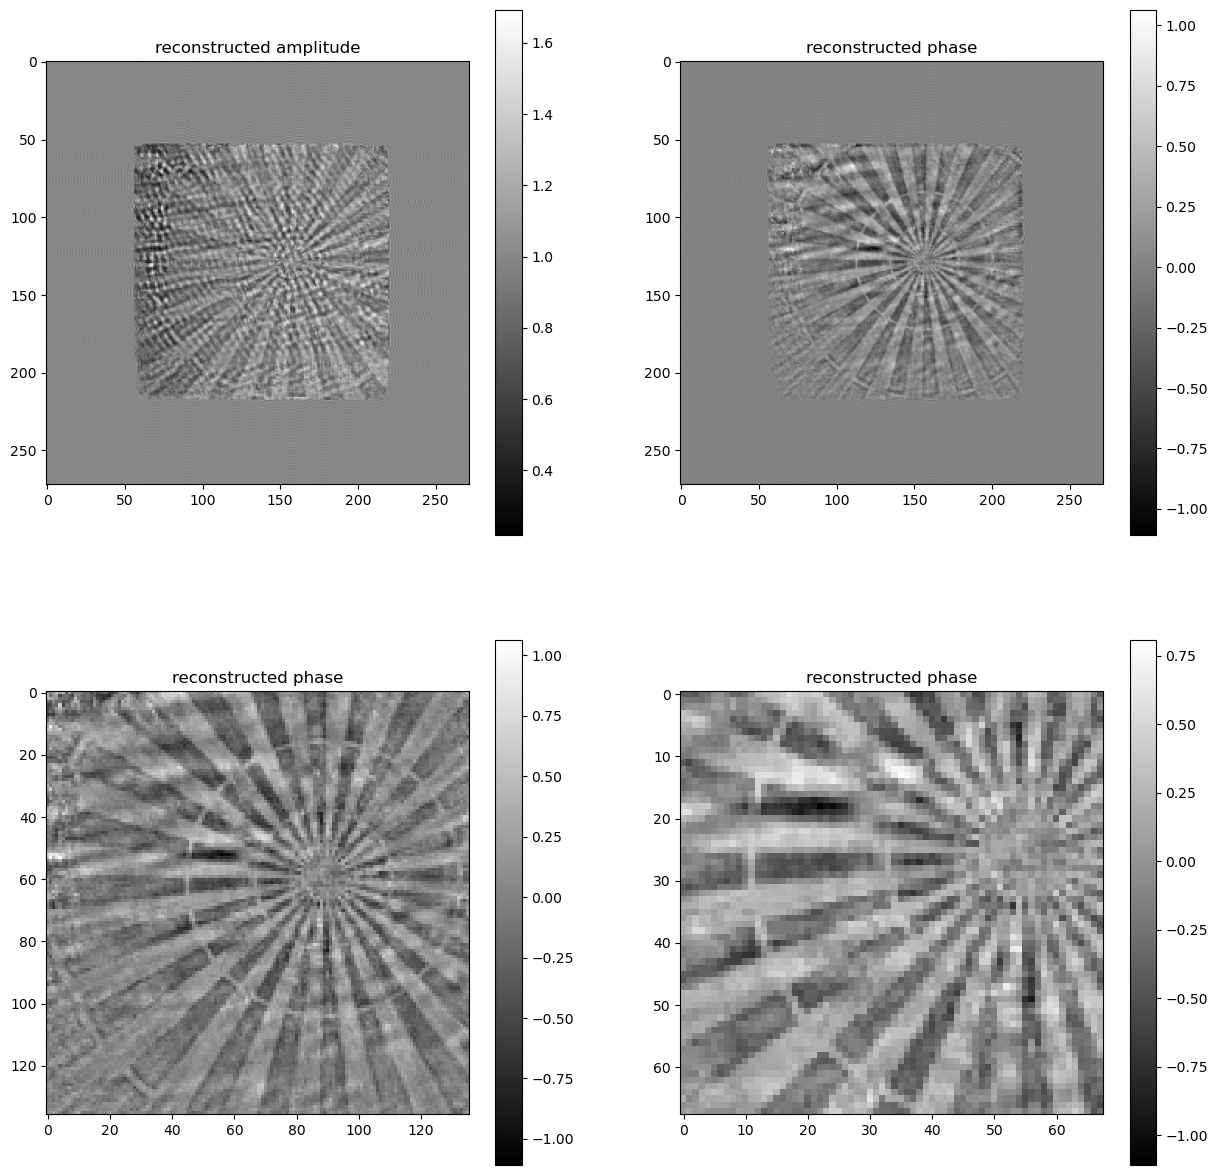

512) gammapsi=0.25, err=2.06905e+07
512) gammaprb=0.25, err=2.06891e+07


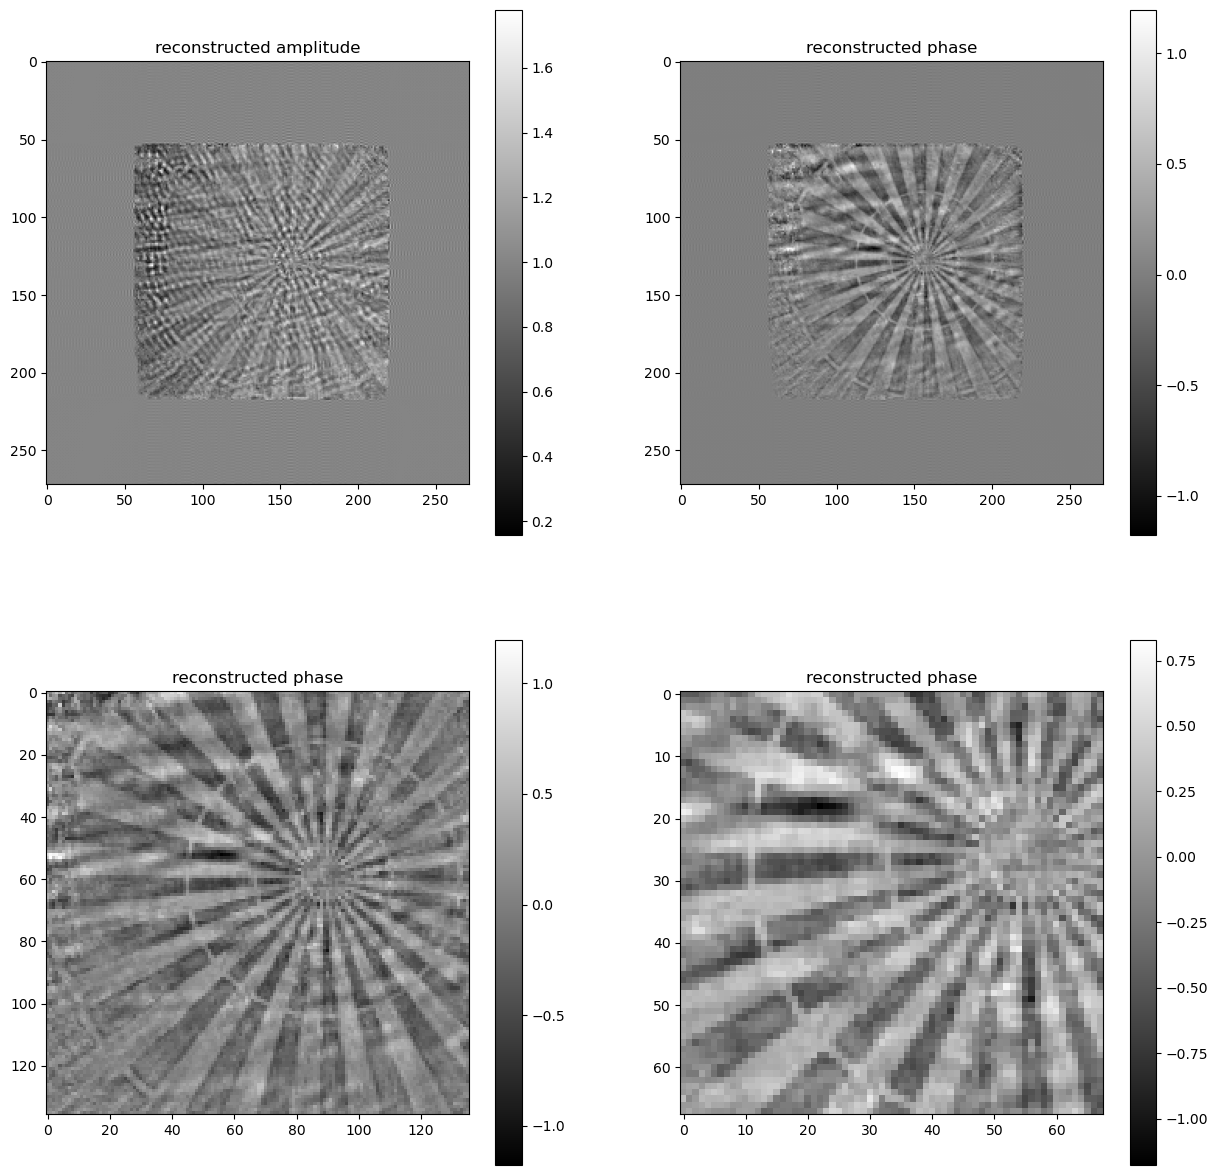

768) gammapsi=0.5, err=2.02441e+07
768) gammaprb=0.5, err=2.02436e+07


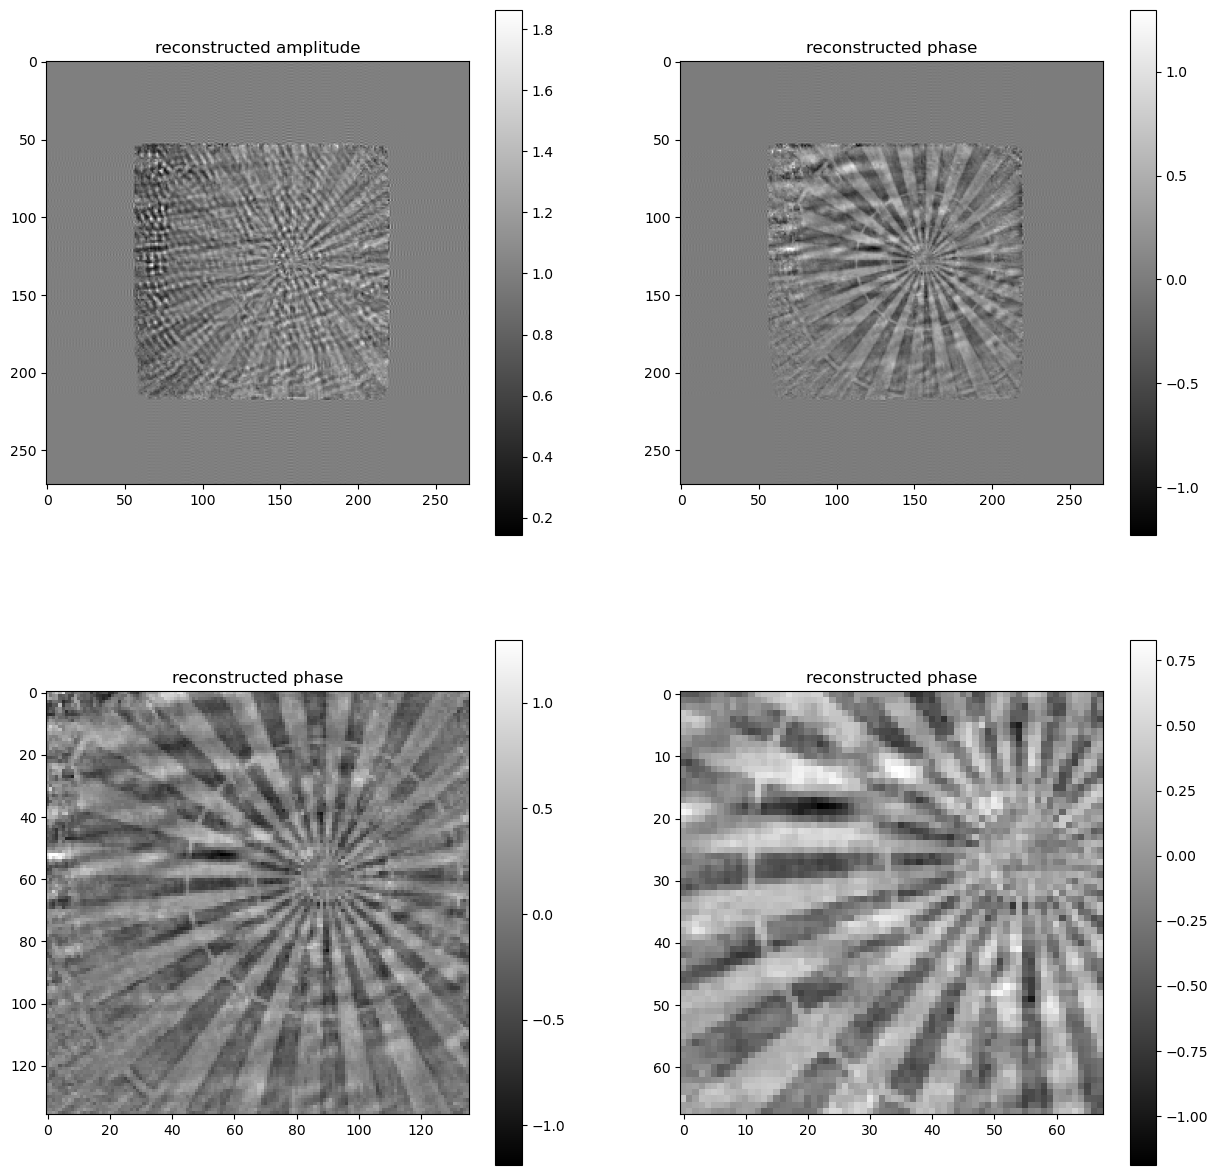

1024) gammapsi=0.5, err=1.99788e+07
1024) gammaprb=0.5, err=1.99784e+07


In [66]:

pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2) 
rec = cp.ones([1,2*n,2*n],dtype='complex64')
rec_prb = rec_prb0.copy()
shifts_rec = shifts/cp.array(norm_magnifications[:,np.newaxis])
rec,rec_prb = cg_holo_batch(pslv, data, rec, rec_prb, 1025, shifts_rec, True, True, 256)

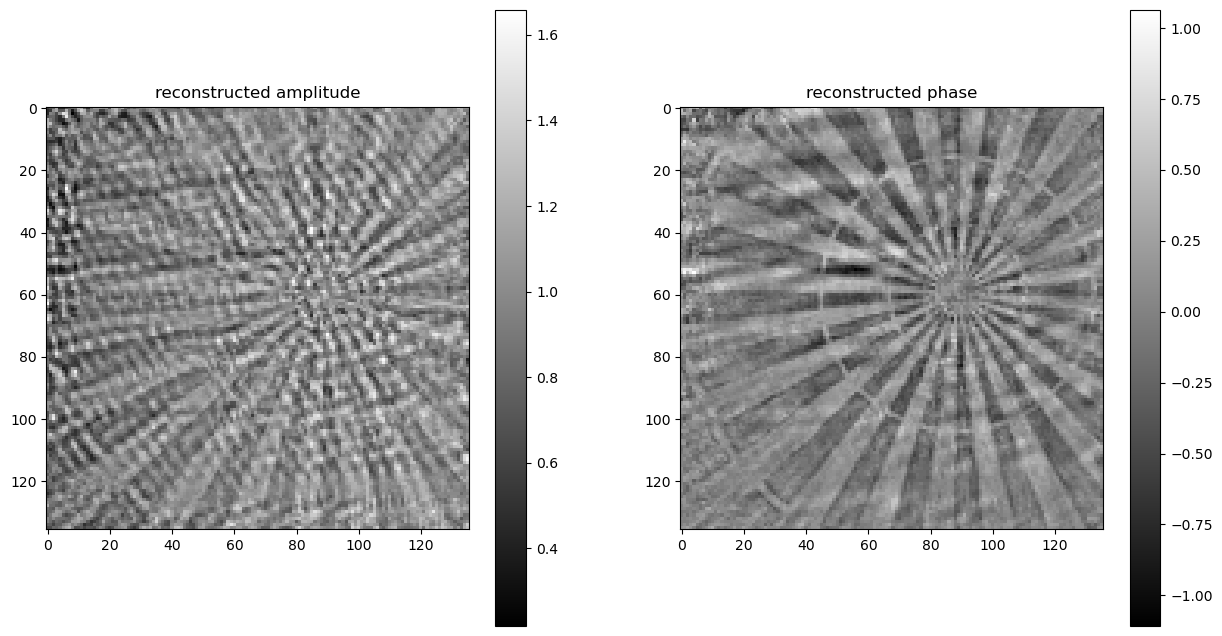

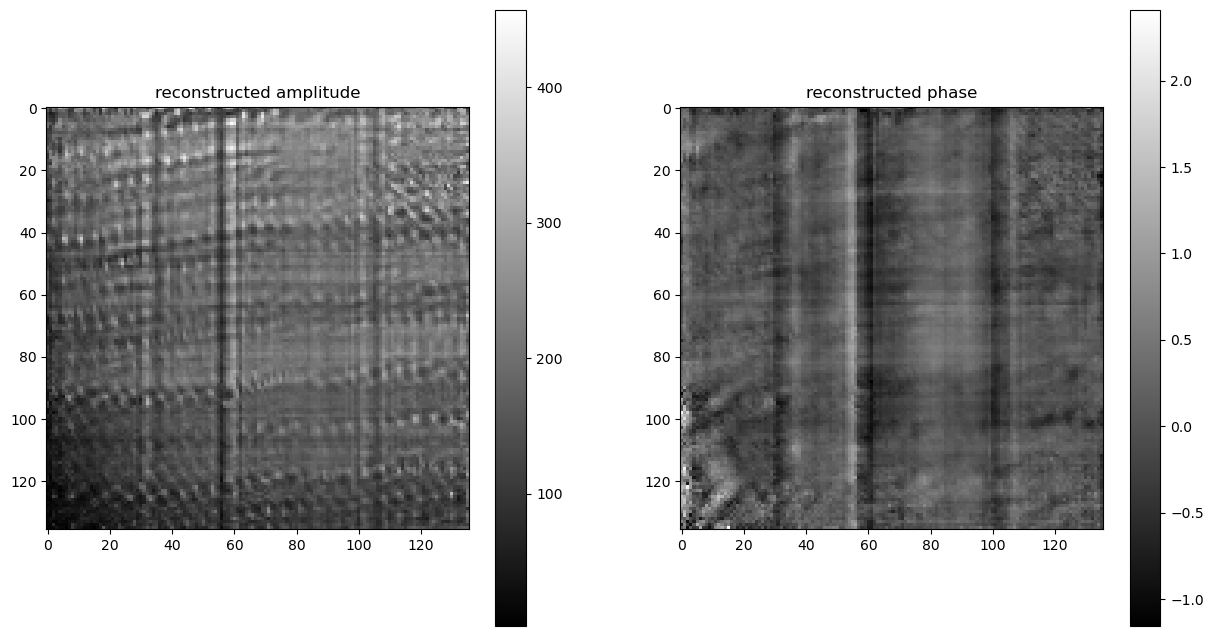

In [65]:

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec_prb[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec_prb[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)